In [1]:
# импортируем библиотеки
# Нам понадобятся стандартные pandas, numpy и matplotlib для работы с данными, расчетов и визуальзации
# также spacy для работы с текстом, seaborn для построения модели и другие.
# Недостающие библиотеки импортируем по ходу.

import spacy
import pandas as pd
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import nltk
import collections

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [16]:
# предварительно смотрим на датасет
tweets = pd.read_csv('ttt.csv', encoding = "cp1251", delimiter = ";")
tweets.head()
a = tweets["Краткое\nсодержание"]
#print(a)

In [18]:
tweets.head()

,№ п/п,№\nдокумента,Дата\nрегистрации,Исх. №\nДата,Адресат,Автор,Краткое\nсодержание,Примечание
0,1,WSR/1-838/2019,43564.0,208-409\n08.04.2019,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...,NaN
1,2,WSR/1-837/2019,43564.0,05-338\n09.04.2019,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...,NaN
2,3,WSR/1-835/2019,43564.0,И10-14/3137\n09.04.2019,Уразов Р.Н.,Цивилев С.Е. (Администрация Кемеровской области),Вх - О командировании Саликовой К. и Глушко Д....,NaN
3,4,WSR/1-834/2019,43564.0,Д2/7121-ИС\n03.04.2019,Иванюк Л.А.,Волков Г.А. (Министерство транспорта Российско...,Вх - Об участии в Чемпионате мира по профессио...,NaN
4,5,WSR/1-833/2019,43564.0,15-20/06-911\n08.04.2019,Уразов Р.Н.,Атанов И.В. (Ставропольский государственный аг...,Вх - Об участии в церемонии открытия Вузовског...,NaN


In [33]:
#определим кол-во твитов в датасете по классам
b = a.value_counts()
b = b.head(15)
print(b)

Вх - О составе СМИ на WorldSkills Kazan 2019                                                                                                                                                              51
Вх - О направлении заявки на проведение демонстрационного экзамена по стандартам Ворлдскиллс Россия в 2019 году                                                                                           32
Вх - Об участии в финале II Национального межвузовского чемпионата «Молодые профессионалы (Ворлдскиллс Россия)»                                                                                           30
Вх - О представителе в Региональном совете Союза                                                                                                                                                          28
О направлении заявки на отбор субъектов РФ для участия в пилотной апробации проведения демонстрационного экзамена по стандартам Ворлдскиллс Россия в 2018 году                      

In [7]:
#выборка несбалансирована, поэтому можно попробовать объединить нейтральные и позитивные в 1 класс
# твиты с уверенностью меньше 0.65 можно убрать
tweets_conf = tweets[tweets['airline_sentiment_confidence'] >= 0.65]
tweets_conf.airline_sentiment_confidence.value_counts()

1.0000    10445
0.6667       71
0.6632       35
0.6596       30
0.6559       30
          ...  
0.7022        1
0.7991        1
0.9633        1
0.6928        1
0.7135        1
Name: airline_sentiment_confidence, Length: 619, dtype: int64

30.0
20.0


<AxesSubplot:>

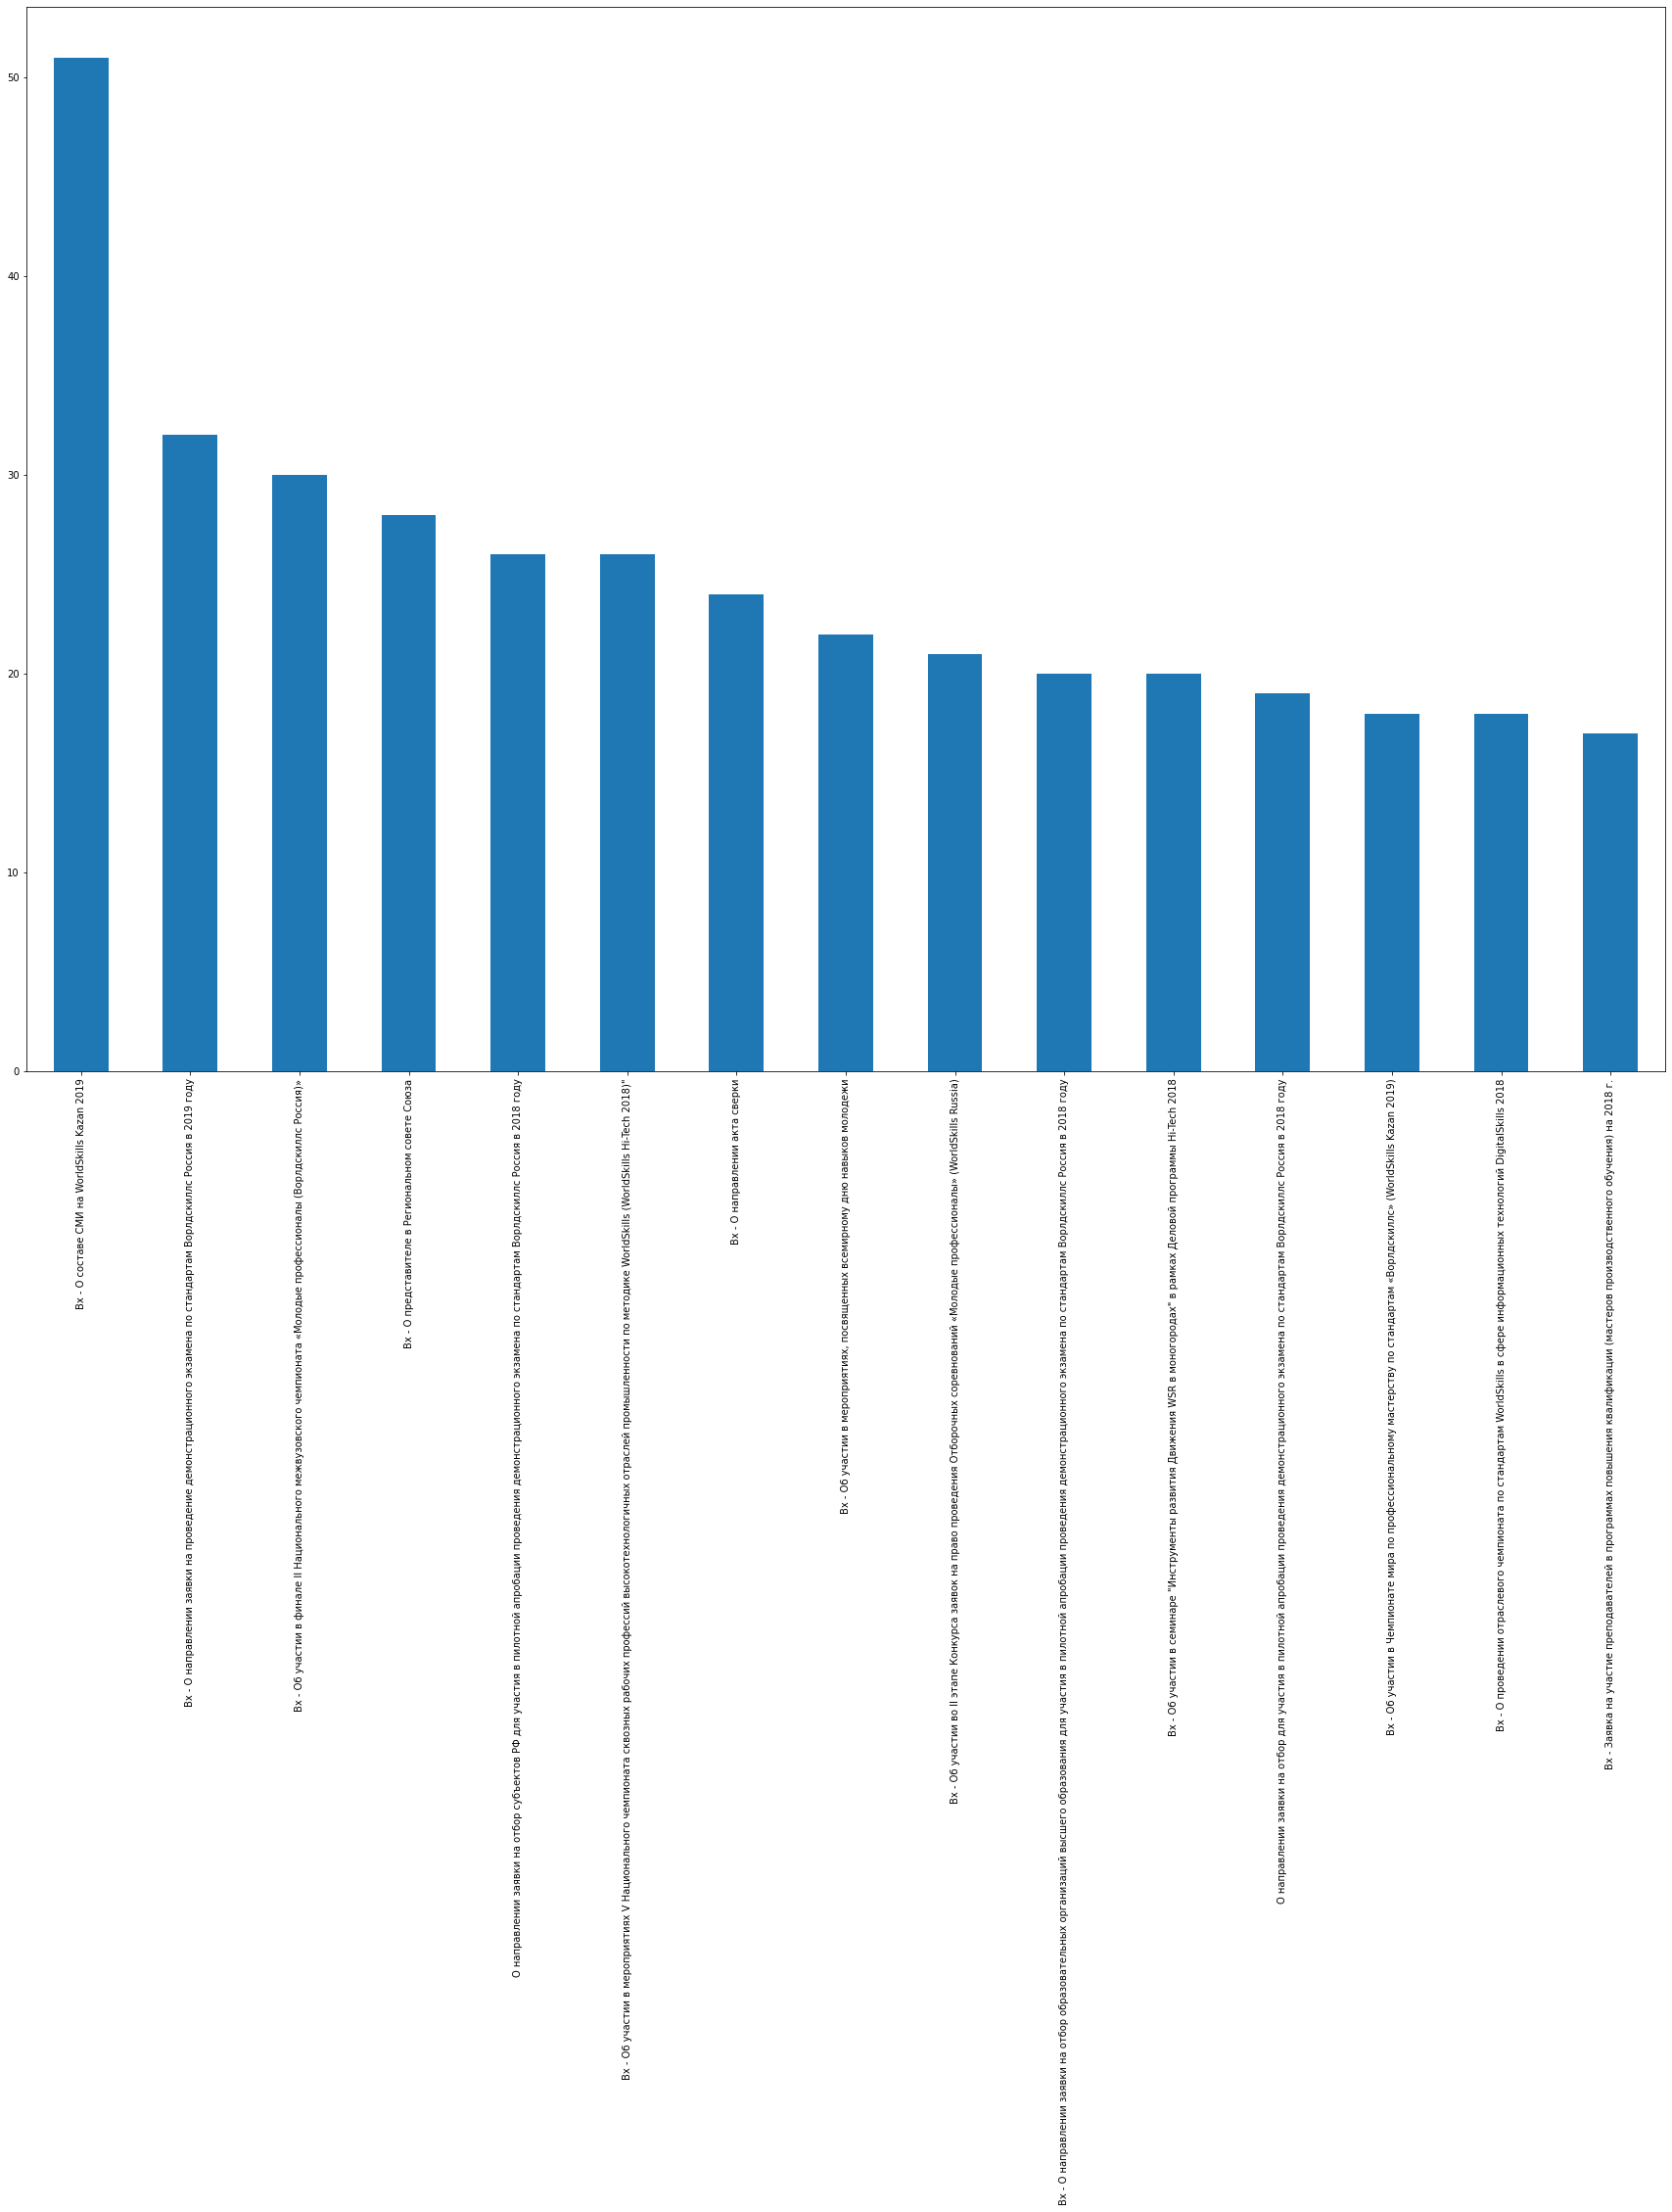

In [42]:
# смотрим структуру твитов по компаниям
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 30
plot_size[1] = 20
plt.rcParams["figure.figsize"] = plot_size 

b.plot(kind='bar', autopct='%1.0f%%')

<AxesSubplot:ylabel='airline_sentiment'>

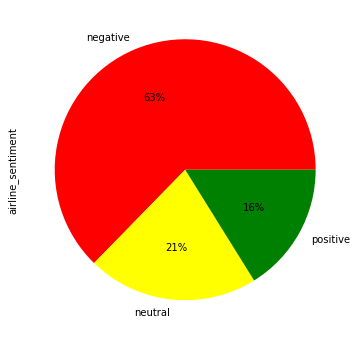

In [9]:
# доля каждого из классов
tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

<AxesSubplot:xlabel='airline'>

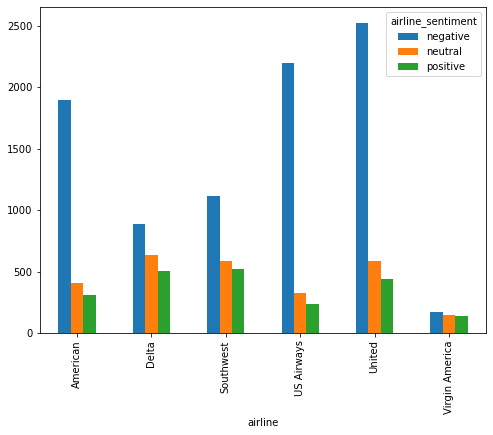

In [10]:
#Разбивка по классам для каждой компании
airline_sentiment = tweets_conf.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [43]:
#смотрим структуру самих твитов
tweets.text

AttributeError: 'DataFrame' object has no attribute 'text'

#### видим что первым токеном идет в основном тэг с именем авиакомпании, вторым как предлог или местоимение, их можно удалить

In [12]:
#отфильтруем данные
list(tweets_conf.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [13]:
#оставим только нужные столбцы
df_tweets = tweets_conf[['airline_sentiment','airline','text']]

In [14]:
#делаем нормализацию текста твитов с помощью nltk, т.к. это одна из самых распространенных,
#удобных и эффертивных библиотек для распознавания человеческого языка.
#Лемотизируем текст, т.е. приведем каждое слово в его первоначальную форму
#Уберем лишние знаки, приведем все заглавные буквы к прописному виду

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [15]:
import nltk
nltk.download('punkt')

pd.set_option('display.max_colwidth', None)
df_tweets['norm_text'] = df_tweets.text.apply(normalizer)
df_tweets[['text','norm_text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
<ipython-input-15-3cfd0bac7fbd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['norm_text'] = df_tweets.text.apply(normalizer)


,text,norm_text
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,"[would, pay, flight, seat, playing, really, bad, thing, flying, va]"


In [16]:
# выделяем n-граммы
from nltk import ngrams
def ngrams(input_list):
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    return bigrams
df_tweets['grams'] = df_tweets.norm_text.apply(ngrams)
df_tweets[['grams']].head()

<ipython-input-16-6002d58bc17f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['grams'] = df_tweets.norm_text.apply(ngrams)


,grams
0,[dhepburn said]
2,"[today must, must mean, mean need, need take, take another, another trip]"
3,"[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse]"
4,"[really big, big bad, bad thing]"
5,"[would pay, pay flight, flight seat, seat playing, playing really, really bad, bad thing, thing flying, flying va]"


In [17]:
df_tweets

,airline_sentiment,airline,text,norm_text,grams
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,"[dhepburn, said]",[dhepburn said]
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]","[today must, must mean, mean need, need take, take another, another trip]"
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]","[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse]"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]","[really big, big bad, bad thing]"
5,negative,Virgin America,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,"[would, pay, flight, seat, playing, really, bad, thing, flying, va]","[would pay, pay flight, flight seat, seat playing, playing really, really bad, bad thing, thing flying, flying va]"
...,...,...,...,...,...
14634,negative,American,@AmericanAir right on cue with the delays👌,"[cue, delay]",[cue delay]
14636,negative,American,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,"[minute, late, flight, warning, communication, minute, late, flight, called, shitty, customer, svc]","[minute late, late flight, flight warning, warning communication, communication minute, minute late, late flight, flight called, called shitty, shitty customer, customer svc]"
14637,neutral,American,@AmericanAir Please bring American Airlines to #BlackBerry10,"[bring, american, airline, blackberry]","[bring american, american airline, airline blackberry]"
14638,negative,American,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??","[money, change, flight, answer, phone, suggestion, make, commitment]","[money change, change flight, flight answer, answer phone, phone suggestion, suggestion make, make commitment]"


In [18]:
# 20 самых распространенных слов/n-грамм для отрицательных отзывов
neg = df_tweets[df_tweets['airline_sentiment'] == 'negative']
neg.head()

,airline_sentiment,airline,text,norm_text,grams
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]","[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse]"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]","[really big, big bad, bad thing]"
5,negative,Virgin America,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,"[would, pay, flight, seat, playing, really, bad, thing, flying, va]","[would pay, pay flight, flight seat, seat playing, playing really, really bad, bad thing, thing flying, flying va]"
15,negative,Virgin America,@VirginAmerica SFO-PDX schedule is still MIA.,"[pdx, schedule, still, mia]","[pdx schedule, schedule still, still mia]"
17,negative,Virgin America,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,"[flew, nyc, sfo, last, week, fully, sit, seat, due, two, large, gentleman, either, side, help]","[flew nyc, nyc sfo, sfo last, last week, week fully, fully sit, sit seat, seat due, due two, two large, large gentleman, gentleman either, either side, side help]"


In [19]:
#для n-грамм
import itertools

all_neg_ngrams = list(itertools.chain(*neg.grams))

# счетчик
counts_neg_ngrams = collections.Counter(all_neg_ngrams)

counts_neg_ngrams.most_common(20)

[('customer service', 428),
 ('http co', 424),
 ('cancelled flightled', 412),
 ('late flight', 212),
 ('cancelled flighted', 187),
 ('flight cancelled', 179),
 ('late flightr', 138),
 ('hold hour', 126),
 ('flightled flight', 120),
 ('cancelled flight', 119),
 ('flight delayed', 114),
 ('call back', 104),
 ('booking problem', 93),
 ('gate agent', 82),
 ('flight flight', 70),
 ('delayed flight', 68),
 ('hour late', 67),
 ('flight attendant', 57),
 ('wait time', 54),
 ('flighted flight', 53)]

In [26]:
#для слов
all_neg_words = list(itertools.chain(*neg.norm_text))

#счетчик
counts_neg_words = collections.Counter(all_neg_words)

counts_neg_words.most_common(20)

[('flight', 3039),
 ('hour', 1047),
 ('get', 961),
 ('cancelled', 844),
 ('service', 754),
 ('customer', 741),
 ('time', 728),
 ('u', 696),
 ('bag', 636),
 ('hold', 600),
 ('plane', 587),
 ('help', 575),
 ('call', 490),
 ('amp', 483),
 ('delayed', 468),
 ('day', 443),
 ('flightled', 435),
 ('co', 432),
 ('still', 427),
 ('one', 426)]

In [27]:
# 20 самых распространенных слов/n-грамм для позитивных отзывов
pos = df_tweets[df_tweets['airline_sentiment'] == 'positive']
pos.head()

,airline_sentiment,airline,text,norm_text,grams
6,positive,Virgin America,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)","[nearly, every, time, fly, vx, ear, worm, go, away]","[nearly every, every time, time fly, fly vx, vx ear, ear worm, worm go, go away]"
8,positive,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D",[],[]
9,positive,Virgin America,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.","[amazing, arrived, hour, early, good]","[amazing arrived, arrived hour, hour early, early good]"
11,positive,Virgin America,@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D,"[lt, pretty, graphic, much, better, minimal, iconography]","[lt pretty, pretty graphic, graphic much, much better, better minimal, minimal iconography]"
12,positive,Virgin America,@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p,"[great, deal, already, thinking, nd, trip, australia, amp, even, gone, st, trip, yet, p]","[great deal, deal already, already thinking, thinking nd, nd trip, trip australia, australia amp, amp even, even gone, gone st, st trip, trip yet, yet p]"


In [22]:
#для n-грамм
all_pos_ngrams = list(itertools.chain(*pos.grams))

#счетчик
counts_pos_ngrams = collections.Counter(all_pos_ngrams)

counts_pos_ngrams.most_common(20)

[('http co', 209),
 ('customer service', 89),
 ('flight attendant', 25),
 ('quick response', 19),
 ('great flight', 17),
 ('best airline', 15),
 ('great job', 15),
 ('great service', 15),
 ('gate agent', 15),
 ('thank much', 15),
 ('good work', 14),
 ('thanks help', 14),
 ('guy rock', 13),
 ('looking forward', 13),
 ('booking problem', 13),
 ('great customer', 12),
 ('flight crew', 12),
 ('keep good', 12),
 ('cancelled flightled', 12),
 ('love flying', 11)]

In [28]:
#для слов
all_pos_words = list(itertools.chain(*pos.norm_text))

#счетчик
counts_pos_words = collections.Counter(all_pos_words)

counts_pos_words.most_common(20)

[('flight', 391),
 ('thanks', 278),
 ('thank', 211),
 ('http', 209),
 ('co', 209),
 ('great', 179),
 ('service', 156),
 ('u', 129),
 ('guy', 117),
 ('customer', 114),
 ('love', 107),
 ('get', 106),
 ('much', 101),
 ('time', 99),
 ('best', 98),
 ('airline', 94),
 ('good', 93),
 ('help', 77),
 ('crew', 75),
 ('today', 74)]

### Модель прогнозирования класса

In [29]:
# препроцессинг
features = tweets.iloc[:, 10].values
labels = tweets.iloc[:, 1].values

In [30]:
# почистим текст
processed_features = []

for sentence in range(0, len(features)):
    # удалим все специальные символы
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # удалим все одиночные буквы
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Удалим одиночные буквы с начала
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Заменим посторяющиеся пробелы одиночными
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Конвертируем все заглавные в прописные буквы
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [31]:
# Приводим текстовые данные в числовую форму для дальнейшего построения модели
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [32]:
# Разбиваем данные на тренировочный и тестовый наборы
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [33]:
# обучаем модель. Используем RandomForestClassifier, как один из лучших видов классификаторов для наборов данных с большим числом наблюдений.
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [34]:
# Сохраняем модель в переменную
predictions = text_classifier.predict(X_test)

In [36]:
# проверяем точность модели, используя confusion matrix с F1 мерой 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995


Позитивные и негативные твиты, как мы можем видеть, предсказываются хорошо, т.к. они как правило имеют некоторые отличительные слова, в чем мы убедились, отобрав самые 20 распространенных слов для тех и других.
Самый высокий процент правильно предсказанных твитов у негативных твитов, чего и следовало ожидать.

Вместе с тем, нейтральные твиты предсказать сложнее, поскольку они не имеют таких отличительных черт.